![logo](../../LogoLine_horizon_C3S.png)

<div class="alert alert-block alert-warning">
Please note that this repository is used for development and review, so quality assessments should be considered work in progress until they are merged into the main branch
</div>

# Validation of CERRA for application in urban adaptation to climate extremes

Production date: 24-05-2024

Produced by: Sandro Calmanti (ENEA), Chiara Volta (ENEA)

## 🌍 Use case: Monitoring the heat-waves over urban areas

## ❓ Quality assessment question:

* What is the added value of using  CERRA in assessing the impact of heat waves over urban areas compared to ERA5 and ERA5-Land?

This notebook presents an assessment of the potential added value of the reanalysis CERRA [[1]]( https://doi.org/10.1002/qj.4764) compared to the coarser resolution reanalyses ERA5 and ERA5-Land. While ERA5 and ERA5-Land data have a spatial resolution of 0.1° x 0.1° (about 10 km) and 0.25° x 0.25° (about 25 km), respectively, CERRA resolution is 5.5 km owing to its utilization of a layered model for the Earth's surface (SURFEXV8.1), which offers a more comprehensive representation of surface topography and physiographic data [[2]](https://confluence.ecmwf.int/display/CKB/Copernicus+European+Regional+ReAnalysis+%28CERRA%29%3A+product+user+guide). As a consequence, CERRA is expected to provide a more accurate information concerning meteorological variables.  The three datasets also differ in terms of temporal resolution (1 hour in ERA5 and ERA5-Land, 3 hours in CERRA) and reanalysis methods, which rely on data assimilation in CERRA and ERA5 (i.e., 3D-VAR and 4D-VAR, respectively) and simulations forced by the atmospheric forcing of ERA5 in ERA5-Land [[2]](https://confluence.ecmwf.int/display/CKB/Copernicus+European+Regional+ReAnalysis+%28CERRA%29%3A+product+user+guide) [[3]](https://rmets.onlinelibrary.wiley.com/doi/full/10.1002/qj.3803) [[4]](https://essd.copernicus.org/articles/13/4349/2021/).   
The analysis performed in this notebook compares the three datasets to examine the quality of CERRA in accurately describing the distribution of temperature extremes during August 2020 in the area around Rome (i.e., Lazio, Italy; see map below), a region characterized by the coexistence of different climatic regimes due to its abundant orographic features and variety of land use properties [[5]](https://www.int-res.com/abstracts/cr/v62/n3/p173-188/).  
The overall objective of this analysis is to provide valuable insights into the utility of CERRA as a reference dataset for climate impact studies, which encompass the bias correction of climate predictions and longer-term projections [[6]](https://journals.ametsoc.org/view/journals/clim/28/17/jcli-d-14-00754.1.xml) [[7]](https://www.sciencedirect.com/science/article/pii/S2405880717300067?via%3Dihub), including the challenge of correcting extremes [[8]](https://www.mdpi.com/2225-1154/11/1/3).

```{figure} a481576a-8c31-41e1-b664-0ebd239037a4.png
---
height: 500px
---
The full geographical domain of CERRA and, highlighted in red, the focus area for the quality assessment presented in this notebook. 
```

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* CERRA provides an accurate description of local temperature values, taking into account the effect of orographic features at a uniform horizontal resolution of 5.5 km.
* The analysis of climate extreme, such as heat waves over urban areas, is expected to benefit from the adoption of CERRA as a reference dataset.
* CERRA represents a suitable reference for the downscaling and bias correction of climate predictions and long-term projections.
* The geographical coverage of CERRA is limited to the European region. Therefore, applications based on CERRA are not replicable outside Europe.
```

## 📋 Methodology

The analysis focuses on maximum temperature data from the [CERRA reanalysis](https://cds.climate.copernicus.eu/datasets/reanalysis-cerra-single-levels?tab=overview) over central Italy during the period 1986-2020. The analysis and results are organized in the following steps, which are detailed in the sections below:

**[](reanalysis_reanalysis-cerra-single-levels_climate-and-weather-extremes_q02:section-1)**
* Import required packages
* Define data request
    
**[](reanalysis_reanalysis-cerra-single-levels_climate-and-weather-extremes_q02:section-2)**
* The maximum temperature function
* Datasets retrieval
    
**[](reanalysis_reanalysis-cerra-single-levels_climate-and-weather-extremes_q02:section-3)**
* Display results
* Discussion 

## 📈 Analysis and results

(reanalysis_reanalysis-cerra-single-levels_climate-and-weather-extremes_q02:section-1)=
### 1. Choose the data to use and setup the code
#### Import required packages
Besides the standard libraries `xarray` for the handling of datasets and `matplotlib` for the graphical outputs, we use `cartopy` for the map projection functions. We also use one of the `utils` included in the [C3S EQC custom function](reanalysis_reanalysis-cerra-single-levels_climate-and-weather-extremes_q02:idBOpen) `c3s_eqc_automatic_quality_control` to crop the CERRA dataset over the area of interest because, differently from ERA5 and ERA5-Land, the reanalysis CERRA does not allow the extraction of areal subsets on retrieval.

In [1]:
import calendar
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
from cartopy.mpl.gridliner import Gridliner
from c3s_eqc_automatic_quality_control import download, plot, utils
plt.style.use('tableau-colorblind10')

#### Define data request
The analysis performed in this notebook focuses on the maximum temperature values calculated using temperature data at a height of 2m above the surface (i.e., t2m) from CERRA, ERA5 and ERA5-Land datasets during August 2020 in the Lazio region (Italy). The choice of using a single month of data is made to simplify the analysis without compromising the primary objective of the quality assessment. Indeed, this timeframe proves sufficient to showcase the potential advantages of CERRA compared to ERA5 and ERA5-Land. However, different months and years, as well as different regions (e.g., Alps, Italy and Scandinavia) can be selected and analysed in this notebook.

In [2]:
# Select region of interest
region = "Lazio"
region_slices = {
    "Alps": {"lon_slice": slice(5, 15), "lat_slice": slice(48, 43)},
    "Scandinavia": {"lon_slice": slice(10, 42), "lat_slice": slice(72, 62)},
    "Lazio": {"lon_slice": slice(11, 14), "lat_slice": slice(43, 41)},
    "Italy": {"lon_slice": slice(6, 19), "lat_slice": slice(48, 36)},
}
assert region in region_slices, f"{region=} is invalid"

# Select time range
year_start = 2020
year_stop = 2020

# Select month of interest
month = 8
assert month in range(1, 13), f"{month=} is invalid"

# Define data request
lon_slice = region_slices[region]["lon_slice"]
lat_slice = region_slices[region]["lat_slice"]
lons = tuple((lon + 180) % 360 - 180 for lon in (lon_slice.start, lon_slice.stop))
lats = (lat_slice.start, lat_slice.stop)

requests_dict = {
    "reanalysis-era5-single-levels": {
        "product_type": "reanalysis",
        "format": "grib",
        "variable": "2m_temperature",
        "time": [f"{i:02d}:00" for i in range(24)],
    },
    "reanalysis-era5-land": {
        "product_type": "reanalysis",
        "format": "grib",
        "variable": "2m_temperature",
        "time": [f"{i:02d}:00" for i in range(24)],
        "area": [max(lats), min(lons), min(lats), max(lons)],
    },
    "reanalysis-cerra-single-levels": {
        "variable": "2m_temperature",
        "level_type": "surface_or_atmosphere",
        "data_type": "reanalysis",
        "product_type": "analysis",
        "time": [f"{i:02d}:00" for i in range(0, 24, 3)],
        "format": "grib",
    },
}

(reanalysis_reanalysis-cerra-single-levels_climate-and-weather-extremes_q02:section-2)=
### 2. Datasets retrieval and maximum monthly temperatures

#### The maximum temperature function
Maximum monthly values of temperature for the region of interest are extracted on-the-fly during the download through the `regionalized_max` function.

In [3]:
def regionalised_max(ds, lon_slice=None, lat_slice=None):
    if lon_slice and lat_slice:
        ds = utils.regionalise(ds, lon_slice=lon_slice, lat_slice=lat_slice)
    else:
        assert lon_slice == lat_slice is None
    time = ds["forecast_reference_time"].mean()
    ds = ds.max("forecast_reference_time", keep_attrs=True)
    if "leadtime" in ds.dims:
        time += ds["leadtime"].mean()
        ds = ds.max("leadtime", keep_attrs=True)
    return ds.expand_dims(time=[time.values])

#### Datasets retrieval
The three datasets are downloaded separately through a specific request and data are then organized into one dictionary `datarrays`. Temperature data unit in $K$ is converted in $°C$.

In [4]:
dataarrays = {}
for collection_id, request in requests_dict.items():
    transform_func_kwargs = region_slices[region] if "area" not in region else {}
    requests = []
    for year in range(year_start, year_stop + 1):
        time_request = {
            "year": year,
            "month": month,
            "day": list(range(1, calendar.monthrange(year, month)[1] + 1)),
        }
        requests.append(request | time_request)
    ds = download.download_and_transform(
        collection_id,
        requests,
        transform_func=regionalised_max,
        transform_func_kwargs=transform_func_kwargs,
    )
    (varname,) = ds.data_vars
    da = ds[varname].max("time", keep_attrs=True)
    with xr.set_options(keep_attrs=True):
        da -= 273.15
    da.attrs["units"] = "°C"
    dataarrays[collection_id] = da

100%|██████████| 1/1 [00:00<00:00, 10.45it/s]


(reanalysis_reanalysis-cerra-single-levels_climate-and-weather-extremes_q02:section-3)=
### 3. Plot and describe results
#### Display results
Maps of maximum temperature are displayed for each dataset analysed. The map color scale is dynamically adjusted to accommodate maximum and minimum temperature from all datasets and enable a more effective visual analysis.
Normalized histograms of the maximum temperature values depicted in the maps are also shown.

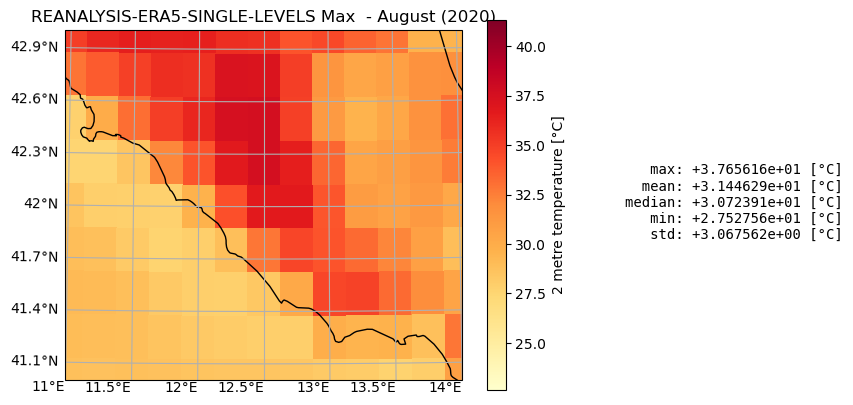

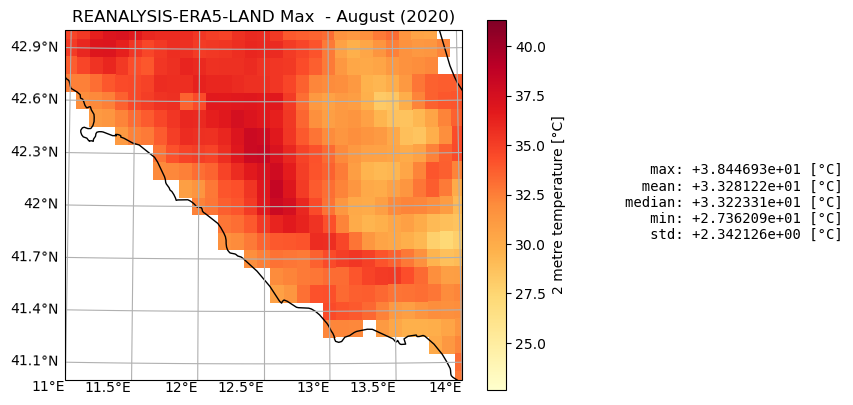

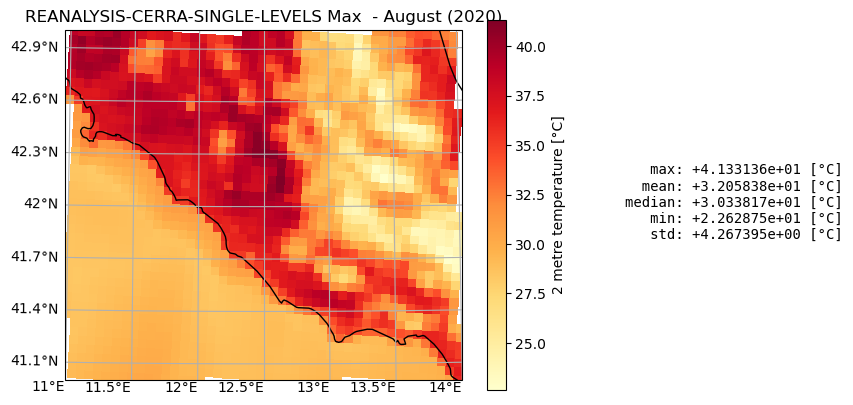

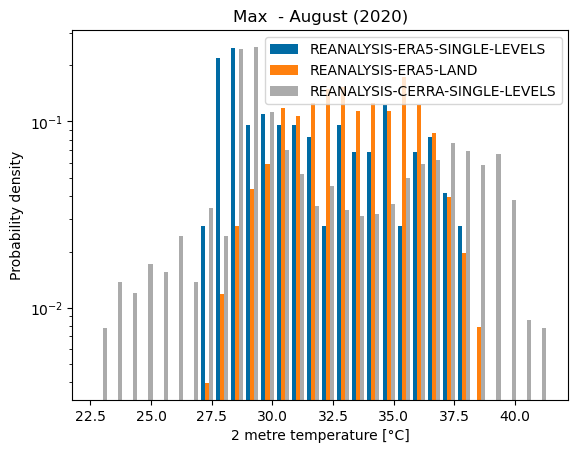

In [5]:
# Set common cbar and map projection projection
vmin = min([da.min().values for da in dataarrays.values()])
vmax = max([da.max().values for da in dataarrays.values()])
lon_slice = region_slices[region]["lon_slice"]
lat_slice = region_slices[region]["lat_slice"]
projection = ccrs.LambertConformal(
    central_longitude=(lon_slice.start + lon_slice.stop) / 2,
    central_latitude=(lat_slice.start + lat_slice.stop) / 2,
)

# Set the longitude and latitude extent of the map
extent = [
    min(lon_slice.start, lon_slice.stop),
    max(lon_slice.start, lon_slice.stop),
    min(lat_slice.start, lat_slice.stop),
    max(lat_slice.start, lat_slice.stop),
]

# Set title
years = sorted(map(str, {year_start, year_stop}))
title = f"Max  - {calendar.month_name[month]} ({'-'.join(years)})"

# Plot maps
for collection_id, da in dataarrays.items():
    plot.projected_map(da, projection=projection, vmin=vmin, vmax=vmax, cmap="YlOrRd")
    plot_obj = plt.title(f"{collection_id.upper()} {title}")
    plot_obj.axes.set_extent(extent)

    # Set the position of longitude labels below the bottom axis
    gridliners = [a for a in plot_obj.axes.artists if isinstance(a, Gridliner)]
    for gl in gridliners:
        gl.x_inline = False
        gl.xlabel_style = {"rotation": 0}
    plt.show()

# Plot histograms
#stacked_data = {
#    collection_id: da.stack(dim=da.dims).values
#    for collection_id, da in dataarrays.items()
#}

stacked_data = {
    collection_id: da.stack(stack_dim=da.dims).values
    for collection_id, da in dataarrays.items()
}

fig, ax = plt.subplots()
ax.hist(
    stacked_data.values(),
    bins=30,
    density=True,
    label=[label.upper() for label in dataarrays],
)
ax.set_yscale("log")
ax.set_xlabel(f"{da.attrs['long_name']} [{da.attrs['units']}]")
ax.set_ylabel("Probability density")
ax.legend()
_ = ax.set_title(title)

#### Discussion
**Maximum temperature maps:** Comparison of the maximum temperature maps for the three datasets shows that CERRA provides a better description of the spatial distribution of maximum temperatures and shows a relatively larger variability than ERA5 and ERA5-Land. Indeed, CERRA is able to clearly distinguish between the warmer coastal areas to the west and the colder mountainous regions to the east, and accurately portrays the key geographical features of the region. In particular, the relatively cold area to the northwest corresponds to Mount Amiata (1738 m), while the eastern region, which includes the Gran Sasso massif (maximum altitude 2912 m), displays the lowest maximum temperature. CERRA also identifies a central area characterized by the warmest temperatures due to the heat island effect from the city of Rome, as well as the presence of volcanic lakes north and south of Rome (i.e., orangish patches within the warmer area in the map) and a southeast area showing a narrow valley between two parallel mountain ridges, which act as hot spot facilitating the recirculation of warm air.  
Moreover, it is worth noticing that, although the range of observed maximum temperature is similar in both ERA5 and ERA5-Land, ERA5-Land offers a more detailed spatial description than ERA5.

**Maximum temperature histogram:** Differences between the three datasets are further illustrated as normalized histograms of the maximum temperature values depicted in the maps. The distribution of temperature values for ERA5 and ERA5-Land drop off sharply around 27 °C and 38 °C, respectively, whereas in the case of CERRA, the distribution's tails extend over a broader range. Consequently, CERRA is expected to greatly enhance the detection of local extremes, as well as the outcome bias-correction and statistical downscaling procedures.

The results presented in this notebook agree with the assessment produced by [[9]](https://www.mdpi.com/2073-4441/12/6/1669) on evapotranspiration. Comparison of the maximum temperatures from the three datasets with highly-resolved observational systems indicate that CERRA is more able to capture horizontal temperature gradients than both ERA5 and ERA5-Land, even in a complex area such as the city of Rome [[10]](https://www.sciencedirect.com/science/article/abs/pii/S2212095522002735?via%3Dihub). Furthermore, numerical comparison with summer average observations for years 2019 and 2020 reported in [[11]](https://www.sciencedirect.com/science/article/abs/pii/S2212095522002735?via%3Dihub) suggests that the maximum temperature would be overestimated by CERRA and ERA5-Land and underestimated by ERA5. However, it is worth noting that monitoring stations are often installed on rooftops, which are typically higher than the 2m reference of the reanalysis datasets and more exposed to wind cooling, and would therefore measure relatively lower temperatures.  

## ℹ️ If you want to know more
### Key resources
* CDS catalogue entries used in this notebook are [CERRA sub-daily regional reanalysis data for Europe on single levels from 1984 to present](https://cds.climate.copernicus.eu/datasets/reanalysis-cerra-single-levels?tab=overview), [ERA5 hourly data on single levels from 1940 to present](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=form) and [ERA5-Land hourly data from 1950 to present](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land?tab=overview)
* Product Documentation for [CERRA](https://cds.climate.copernicus.eu/datasets/reanalysis-cerra-single-levels?tab=doc), [ERA5](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=doc) and [ERA5-Land](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land?tab=doc) is available

(reanalysis_reanalysis-cerra-single-levels_climate-and-weather-extremes_q02:idBOpen)=
Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`, prepared by [BOpen](https://www.bopen.eu/)

### References
[[1]]( https://doi.org/10.1002/qj.4764) Ridal, M., Bazile, E., Le Moigne, P., Randriamampianina, R., Schimanke, S., Andrae, U., ... & Wang, Z. Q. (2024). CERRA, the Copernicus European Regional Reanalysis system. Quarterly Journal of the Royal Meteorological Society.

[[2]](https://confluence.ecmwf.int/display/CKB/Copernicus+European+Regional+ReAnalysis+%28CERRA%29%3A+product+user+guide) Schimanke, S., Isaksson, L., & Edvinsson, L. (2022). Copernicus European Regional ReAnalysis (CERRA): product user guide.

[[3]](https://rmets.onlinelibrary.wiley.com/doi/full/10.1002/qj.3803) Hersbach, H., Bell, B., Berrisford, P., Hirahara, S., Horányi, A., Muñoz-Sabater, J., ... & Thépaut, J-N. (2020). The ERA5 global reanalysis. Quarterly Journal of the Royal Meteorological Society, 146, 1999-2049.

[[4]](https://essd.copernicus.org/articles/13/4349/2021/) Muñoz-Sabater, J., Dutra, E., Agustí-Panareda, A., Albergel, C., Arduini, G., Balsamo, G., ... & Thépaut, J-N. (2021). ERA5-Land: a state-of-the-art global reanalysis dataset for land applications. Earth System Science Data, 13, 4349-4383.

[[5]](https://www.int-res.com/abstracts/cr/v62/n3/p173-188/) Calmanti, S., Dell’Aquila, A., Maimone, F., & Pelino, V. (2015). Evaluation of climate patterns in a regional climate model over Italy using long-term records from SYNOP weather stations and cluster analysis. Climate Research, 62(3), 173-188.

[[6]](https://journals.ametsoc.org/view/journals/clim/28/17/jcli-d-14-00754.1.xml) Cannon, A. J., Sobie, S. R., & Murdock, T. Q. (2015). Bias correction of GCM precipitation by quantile mapping: how well do methods preserve changes in quantiles and extremes?. Journal of Climate, 28(17), 6938-6959.

[[7]](https://www.sciencedirect.com/science/article/pii/S2405880717300067?via%3Dihub) Manzanas, R., Gutiérrez, J. M., Fernández, J., Van Meijgaard, E., Calmanti, S., Magariño, M. E., ... & Herrera, S. (2018). Dynamical and statistical downscaling of seasonal temperature forecasts in Europe: Added value for user applications. Climate Services, 9, 44-56.

[[8]](https://www.mdpi.com/2225-1154/11/1/3) Trentini, L., Dal Gesso, S., Venturini, M., Guerrini, F., Calmanti, S., & Petitta, M. (2022). A Novel Bias Correction Method for Extreme Events. Climate, 11(1), 3.

[[9]](https://www.mdpi.com/2073-4441/12/6/1669) Pelosi, A., Terribile, F., D’Urso, G., & Chirico, G. B. (2020). Comparison of ERA5-Land and UERRA MESCAN-SURFEX reanalysis data with spatially interpolated weather observations for the regional assessment of reference evapotranspiration. Water, 12(6), 1669.

[[10]](https://www.sciencedirect.com/science/article/abs/pii/S2212095522002735?via%3Dihub) Cecilia, A., Casasanta, G., Petenko, I., Conidi, A., Argentini, S. (2023). Measuring the urban heat island of Rome through a dense weather station network and remote sensing imperviousness data. Urban Climate, 47, 101355.